In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")

import torch 

import clip 

import numpy as np 

from PIL import Image, ImageDraw

from tqdm import tqdm 

import sys 
import os 
import time 
import json 
import re 


In [8]:
text = "Touchdown is on top of the orange newspaper stand"
chunks = list(nlp(text).noun_chunks)

In [4]:
for c in chunks:
    print([(d, d.pos_) for d in nlp(c.text)])

NameError: name 'chunks' is not defined

In [7]:
class paths:
    panorama = '/data1/saaket/jpegs_manhattan_touchdown_2021/'
    pano_slice = '/data1/saaket/lsd_data/data/processed/pano_slices/'
    touchdown= '/data1/saaket/touchdown/data/'
    train = touchdown + 'train.json'
    dev = touchdown + 'dev.json'
    test = touchdown + 'test.json'
    train_pano_feature_files = [
        'image_features_sdr_pano_train_1000.pth',
        'image_features_sdr_pano_train_2000.pth',
        'image_features_sdr_pano_train_3000.pth', 
        'image_features_sdr_pano_train_4000.pth', 
        'image_features_sdr_pano_train_5000.pth',
        'image_features_sdr_pano_train_end.pth'
        ]
    dev_pano_feature_files = [
        'image_features_sdr_pano_dev.pth', 
        'image_features_sdr_pano_dev_350_700.pth', 
        'image_features_sdr_pano_dev_700_1050.pth', 
        'image_features_sdr_pano_dev_1050_end.pth'
    ]
    train_perspective_feature_files = [
        [
            '/data2/saaket/features_image/image_features_sdr_perspective_train0_10.pth',
            '/data2/saaket/features_image/image_features_sdr_perspective_train10_20.pth',
            '/data2/saaket/features_image/image_features_sdr_perspective_train20_30.pth',
            '/data2/saaket/features_image/image_features_sdr_perspective_train30_40.pth',
            '/data2/saaket/features_image/image_features_sdr_perspective_train40_5000.pth',
            '/data2/saaket/features_image/image_features_sdr_perspective_train5000_10000.pth',
        ],
        [
            '/data2/saaket/features_image/image_features_sdr_perspective_train10000_15000.pth',
            '/data2/saaket/features_image/image_features_sdr_perspective_train15000_20000.pth',
        ],
        [
            '/data2/saaket/features_image/image_features_sdr_perspective_train20000_25000.pth',
            '/data2/saaket/features_image/image_features_sdr_perspective_train25000_30000.pth',
        ],
        [
            '/data2/saaket/features_image/image_features_sdr_perspective_train30000_35000.pth',
            
        ],
        [
            '/data2/saaket/features_image/image_features_sdr_perspective_train35000_44456.pth',
        ]
    ]
    dev_perspective_feature_files = [
        '/data2/saaket/features_image/image_features_sdr_perspective_dev_5000.pth',
        '/data2/saaket/features_image/image_features_sdr_perspective_dev_end.pth',
    ]


In [ ]:
text = "a row of blue bikes, Touchdown is in the fifth bike seat in the row, from the way you came."
def find_objects_in_text(text):
    doc = nlp(text)
    objects_in_image = []
    for oid, obj in enumerate(doc.noun_chunks):
        tags = [t.tag_ for t in nlp(obj.text)]
        if 'NN' in tags or 'NNS' or 'NNP' in tags:
            if 'touchdown' not in obj.text and 'Touchdown' not in obj.text:
                objects_in_image.append(obj.text)
    return objects_in_image


['blue bikes', 'the fifth bike seat', 'the row', 'the way']

In [ ]:
def detect_objects(image_features, td_text, text_encoder, device):

    objects_in_image = find_objects_in_text(td_text)

    tokens = clip.tokenize(list(objects_in_image).to(device)
    with torch.no_grad():
        text_features = text_encoder.encode_text(tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity_scores = image_features @ text_features.T 

    return similarity_scores 
    
def get_pano_slice_names(panoid):
    return [f"{panoid}_{i}" for i in range(8)]

def fix_outlier_boxes(bounding_boxes):
    for boxes_in_image in bounding_boxes:
        for box in boxes_in_image:
            if box[0] == box[2]:
                box[2] = box[0] + 1
            if box[1] == box[3]:
                box[3] = box[1] + 1
    return bounding_boxes

def annotate_regions_test(bounding_boxes, panoids, slice2id, texts, model, device, good_boxes):
    best_bounding_boxes = []
    
    image_features = torch.vstack([torch.load(ifeat, map_location=device).to(device) for ifeat in paths.dev_perspective_feature_files])

    for i, panoid in enumerate(tqdm(panoids)): 
        pano_slice_names = get_pano_slice_names(panoid)
        pano_slice_ids = [slice2id[j] for j in pano_slice_names]
        
        td_text = texts[i]
        image_features_start = 1000*(pano_slice_ids[0])
        image_features_end = 1000*(pano_slice_ids[-1] + 1)
        
    
        scores = detect_regions(image_features[image_features_start:image_features_end], td_text, model, device)
        
        consider_boxes = torch.tensor(good_boxes[image_features_start:image_features_end]).to(device)
        # consider_boxes = good_boxes.to(device)

        scores = scores*consider_boxes[:, None]
        
        best_box_indices = torch.tensor(scores.argmax(dim=0).cpu().tolist())


        slice_indices = [si // 1000 for si in best_box_indices]
        offsets = [off % 1000 for off in best_box_indices]
        bboxes = bounding_boxes[pano_slice_ids]
        best_bbox = [(slice_indices[count], bboxes[slice_indices[count]][offsets[count]]) for count in range(len(slice_indices))]
        
        best_bounding_boxes.append(best_bbox)
    return best_bounding_boxes

## Correctness check


In [11]:
def add_prompt_to_touchdown_text(text, object_in_text, colors):
    text2color = {}
    doc = nlp(text)
    doc_list = list(doc)
    doc_list = [d.text for d in doc_list]
    color_counter = 0
    color_order = []
    duplicates = []
    for oid, obj in enumerate(list(reversed(object_in_text))):
        obj_str, start, end = obj 
        if obj_str not in text2color:
            text2color[obj_str] = colors[color_counter % len(colors)]
            
            duplicates.append(0)
        else:
            duplicates.append(1)
        color_order.append(text2color[obj_str])
        doc_list.insert(end, f'in {text2color[obj_str]} color')
        color_counter += 1
    out = " ".join(doc_list)
    return re.sub(r'\s([?.!"](?:\s|$))', r'\1', out.strip()), list(reversed(color_order)), duplicates 

In [33]:
def get_unique_panos(data_path):
    '''Compute unique panoramasa from data file. These panos are unique to a particular train/dev/test file'''
    panoids = []
    with open(data_path) as f:
        for idx, line in enumerate(f):
            obj = json.loads(line)
            panoids.append(obj['main_pano'])
    return np.unique(panoids)

def get_pano2id(unique_panos):
    pano2id = {}
    id2pano = {}
    for i, pano in enumerate(unique_panos):
        pano2id[pano] = i 
        id2pano[i] = pano
    return pano2id, id2pano 

def touchdown_loader(data_path, mode):
    texts, panoids, color_annotation_order, duplicate_annotation = [], [], [], [] 
    object_in_text_path = f'/data2/saaket/objects_in_text_{mode}.npy'
    objects_in_text = np.load(object_in_text_path, allow_pickle=True)
    with open(data_path) as f:
        for idx, line in enumerate(f):
            obj = json.loads(line)
            panoids.append(obj['main_pano'])
            object_text = objects_in_text[idx]#find_objects_in_text(obj['td_location_text'])
            text, ca, dup = add_prompt_to_touchdown_text(obj['td_location_text'], object_text, color_names)
            texts.append(text)
            color_annotation_order.append(ca)
            duplicate_annotation.append(dup)
    return texts, panoids, color_annotation_order, duplicate_annotation

In [42]:
def paint_object_bbox(bboxes, image_slices, colors, color_annotation_order, duplicate_annotation):
        alread_annotated = {}
        for enum, slice_and_box in enumerate(bboxes):
            if duplicate_annotation[enum] == 0:
                slice_num, box = slice_and_box 
                x1, y1, x2, y2 = box
                color_index = color_names.index(color_annotation_order[enum])
                color = colors[color_index] 
                print(color)
                image = image_slices[slice_num].copy()
                overlay = Image.new('RGBA', image.size, color+(0,))
                draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
                draw.rectangle((x1, y1, x2, y2), fill=color+(50,))
                image = Image.alpha_composite(image, overlay)
                # draw = ImageDraw.Draw(image)
                # draw.rectangle((x1, y1, x2, y2), outline=color, width=5)
                image_slices[slice_num] = image 
        # Alpha composite these two images together to obtain the desired result.
        
        return image_slices  

In [35]:
color_names = ['red', 'purple', 'yellow', 'blue', 'pink', 'green']
colors = [(240,0,30), (155,50,210), (255,255,25), (0,10,255), (255,170,230), (0,255,0)]

In [36]:
texts, panoids, color_annotation_order, duplicate_annotation = touchdown_loader('/data1/saaket/touchdown/data/dev.json', 'dev')

In [37]:
texts[1]

'The dumpster in red color has a blue tarp in purple color draped over the end closest to you. Touchdown is on the top of the blue tarp in purple color on the dumpster in red color.'

In [38]:
color_annotation_order[1]
duplicate_annotation[1]
panoids[1]

'qpv6nanmJR3jnC0aTfiLBg'

In [45]:
slices = []

for i in range(8):
    slices.append(Image.open(f'/data1/saaket/lsd_data/data/processed/pano_slices/{panoids[1]}/{panoids[1]}_{i}.jpg').convert('RGBA'))

In [23]:
bbox_data = np.load('/data2/saaket/object_annotations_dev_perspective.npy', allow_pickle=True)

In [46]:
out_slices = paint_object_bbox(bbox_data[1], slices, colors, color_annotation_order[1], duplicate_annotation[1])

(240, 0, 30)
(155, 50, 210)


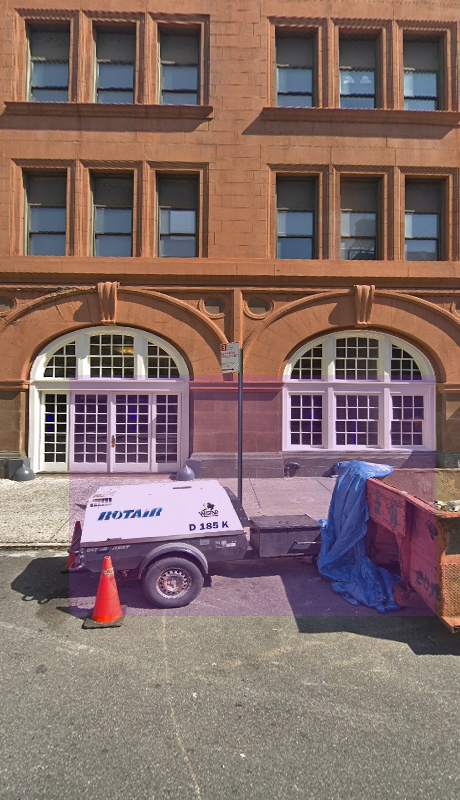

In [47]:
out_slices[2]